In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
%matplotlib inline

In [38]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

In [39]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
dataset_fname = 'bursi.pos.gspan'
def get_graphs(size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

In [40]:
%%time
# induce a grammar and train an estimator
from graphlearn.graphlearn import GraphLearnSampler
training_graphs = get_graphs(size=1500)
sampler=GraphLearnSampler(radius_list=[0,1,2,3], thickness_list=[2,3], min_cip_count=2, min_interface_count=2)
sampler.fit(training_graphs, n_jobs=-1)

CPU times: user 5min 17s, sys: 1min 55s, total: 7min 13s
Wall time: 14min 9s


In [44]:
%%time
# graph sampling
graphs = get_graphs(size=100)
id_start=50
id_end=id_start+12
from itertools import islice
graphs = islice(graphs,id_start,id_end)

#sample
sampler.feasibility_checker.draw_problem=False
graphs = sampler.sample(graphs,
                        n_steps=120, n_samples=6,
                        probabilistic_core_choice=True,
                        same_radius=False,
                        same_core_size=True,
                        accept_annealing_factor=1.3,
                        n_jobs=-1,burnin=0,select_cip_max_tries=200,keep_duplicates=False)

CPU times: user 26 µs, sys: 58 µs, total: 84 µs
Wall time: 83.9 µs


Graph id: 50
printing le errer
grammar
candidates
printing le errer
grammar
candidates


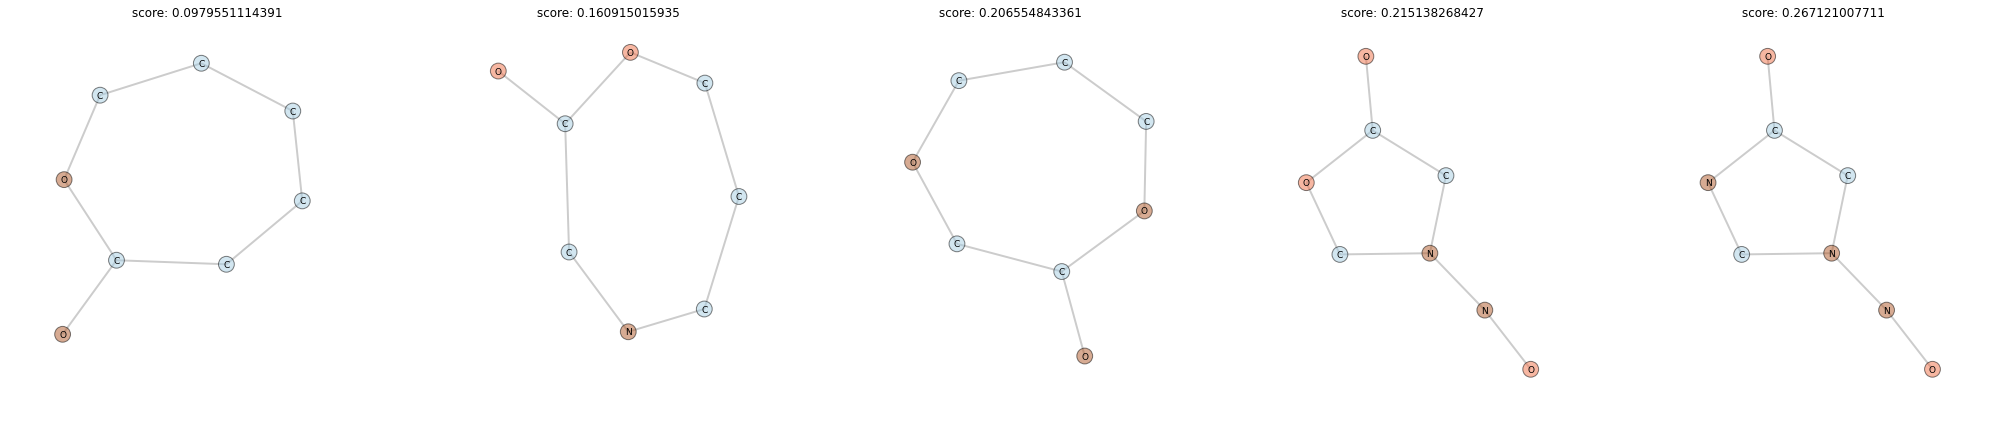

Graph id: 51


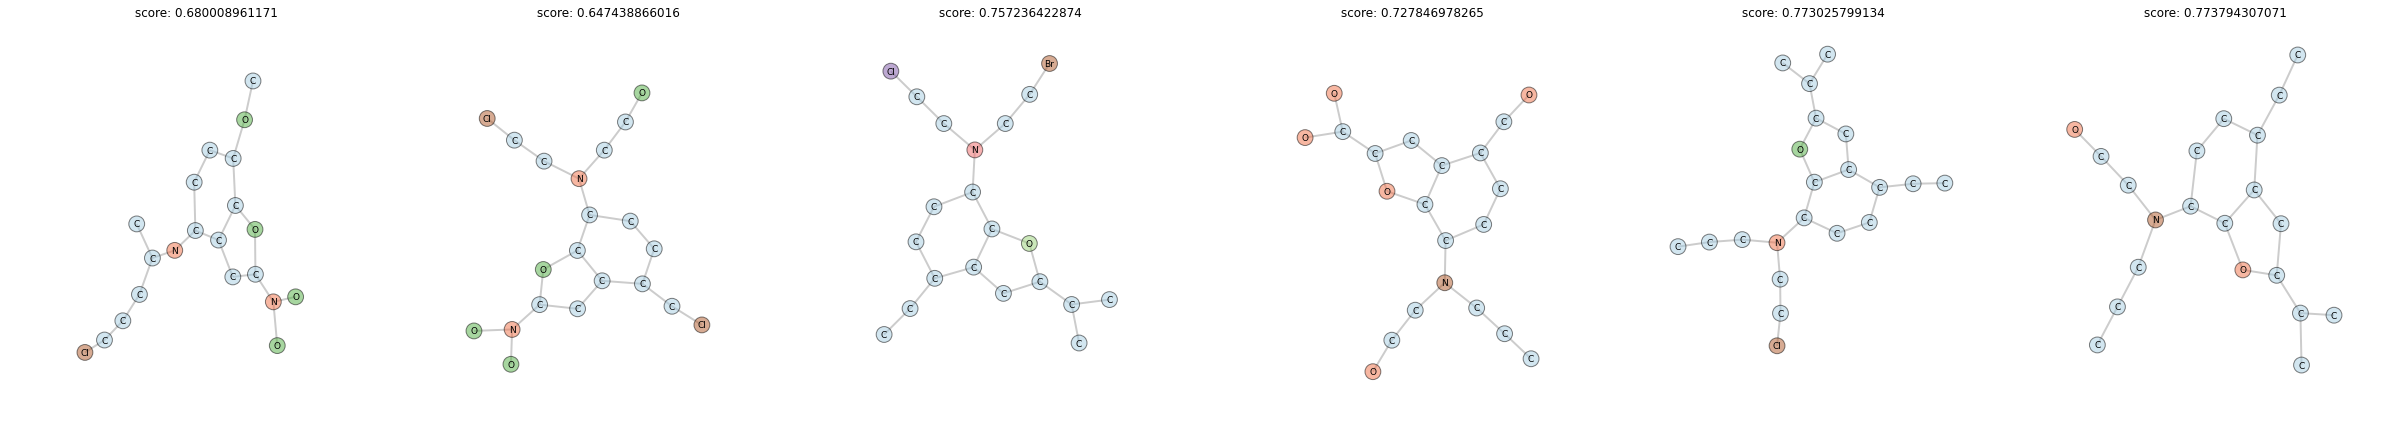

Graph id: 52
printing le errer
grammar
candidates
printing le errer
grammar
candidates
printing le errer
grammar
candidates
printing le errer
grammar
candidates


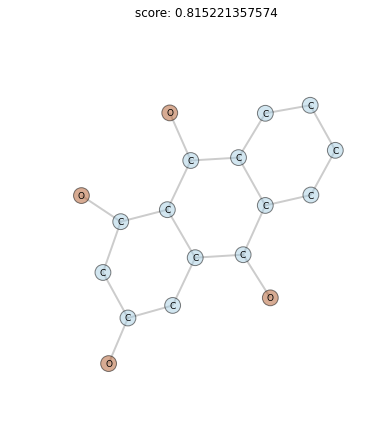

Graph id: 53


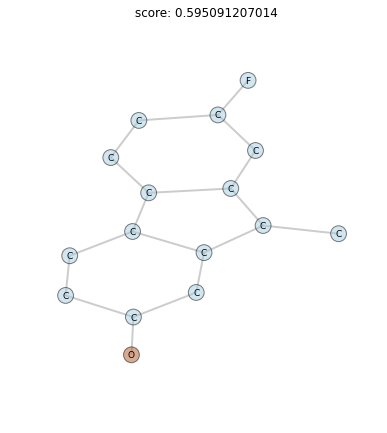

Graph id: 54


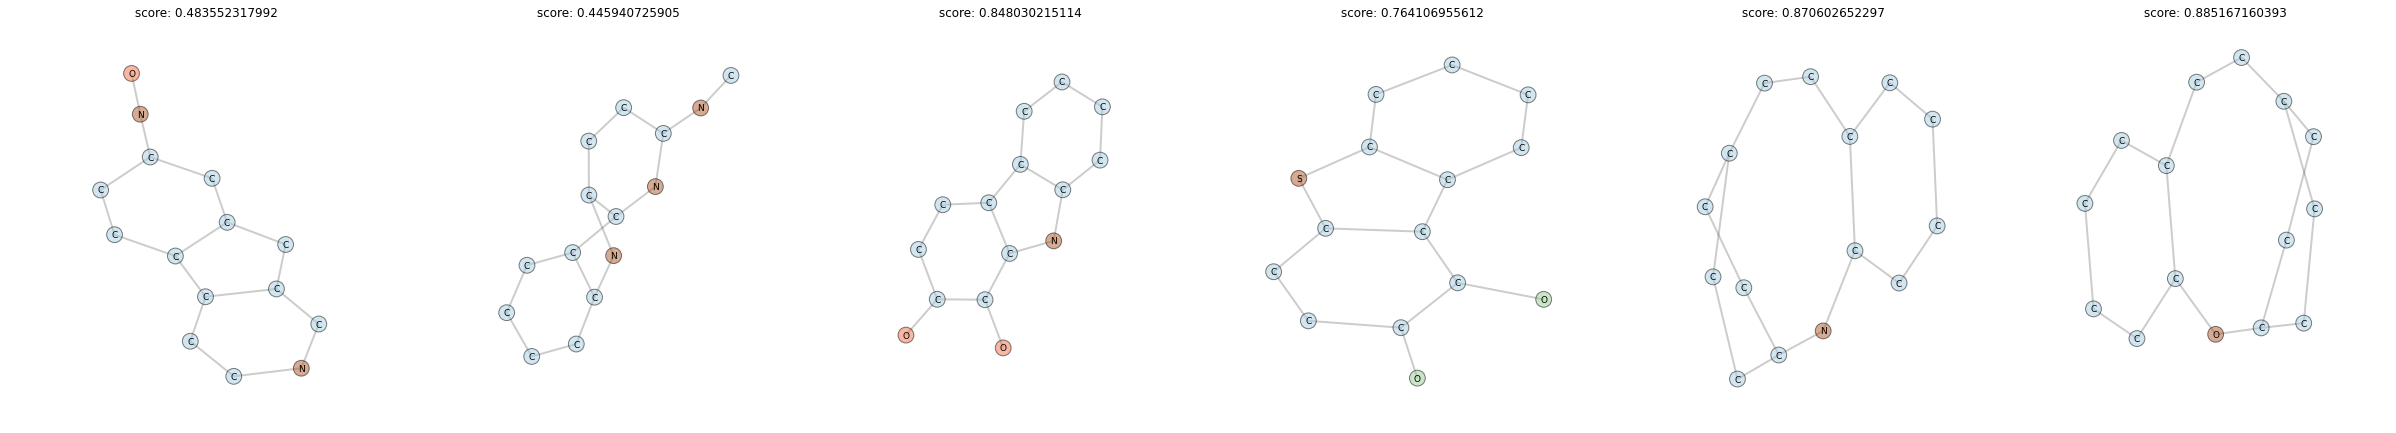

Graph id: 55


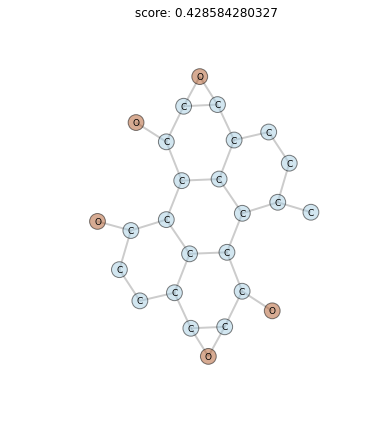

Graph id: 56


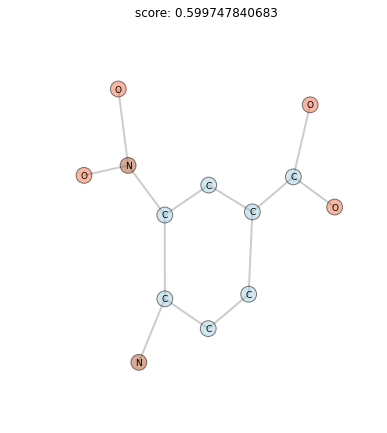

Graph id: 57


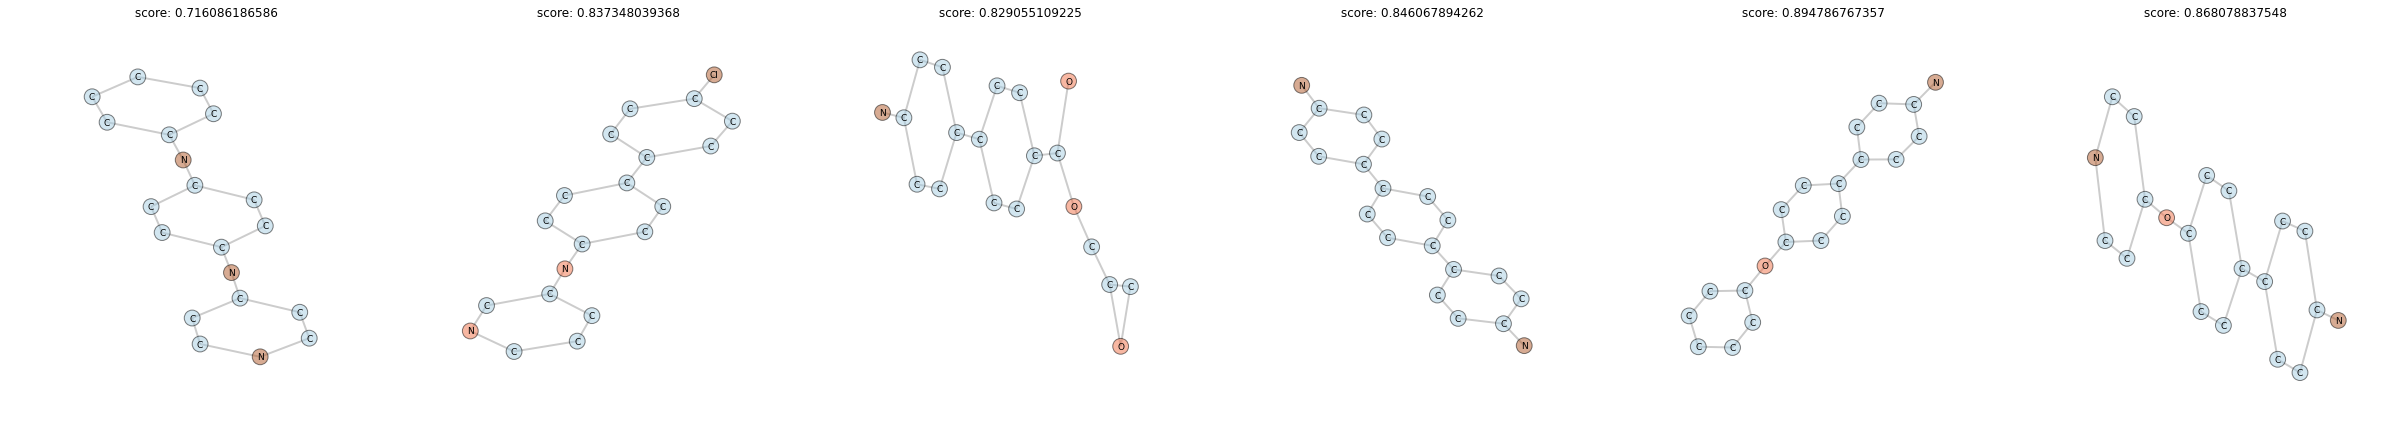

Graph id: 58


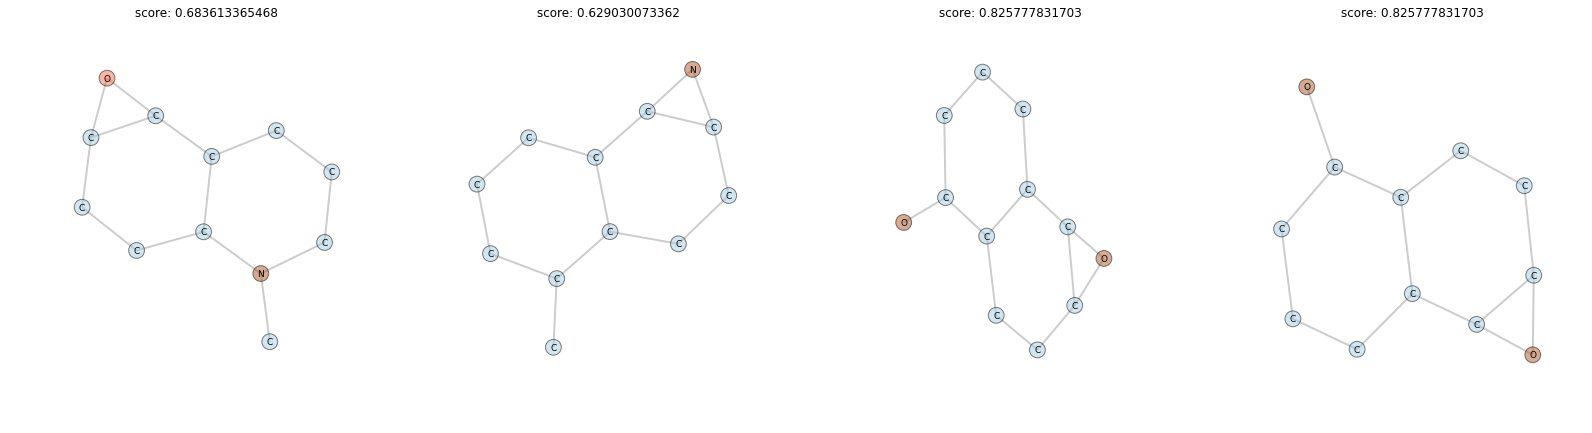

Graph id: 59


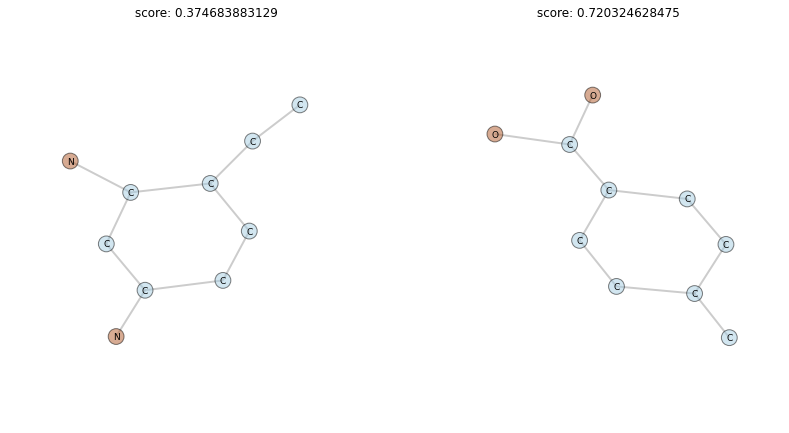

Graph id: 60


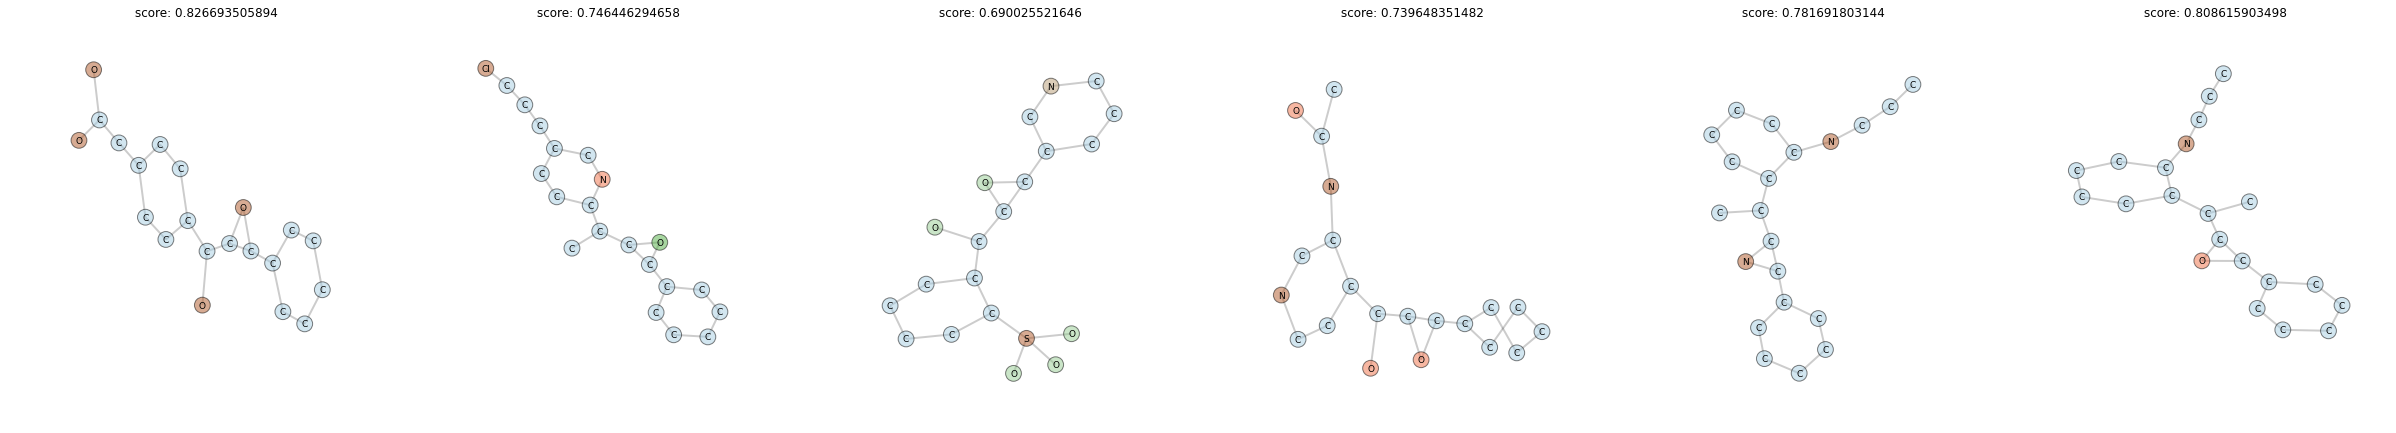

Graph id: 61


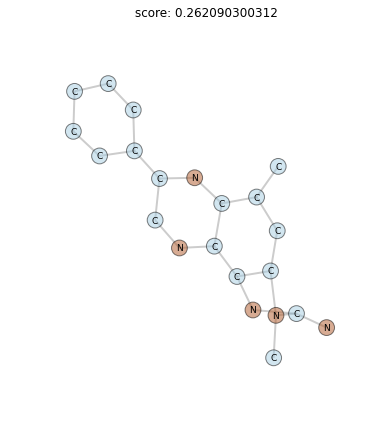

CPU times: user 3min 40s, sys: 45.9 s, total: 4min 26s
Wall time: 7min 36s


In [45]:
%%time
# plot examples of sampling paths
from graphlearn.utils.draw import draw_graph_set_graphlearn, get_score_of_graph
from eden.modifier.graph.vertex_attributes import colorize   
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    path_graphs = colorize(path_graphs,
                           output_attribute = 'color_level', 
                           labels = ['C','O','N','P','Cl','Br','S','I'])
    draw_graph_set_graphlearn(path_graphs,
                   n_graphs_per_line=6, size=7, 
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, edge_alpha=0.2, node_size=250,
                   headlinehook=get_score_of_graph)

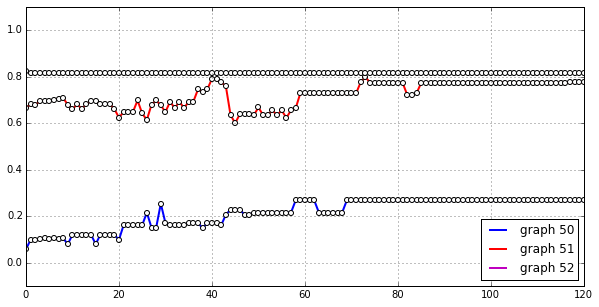

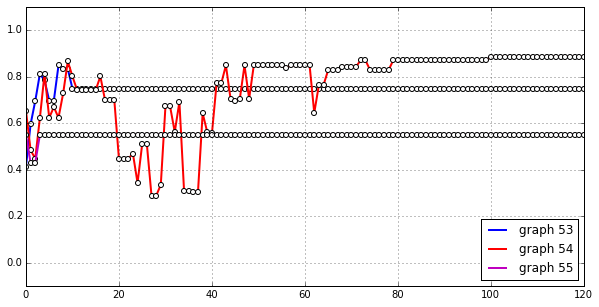

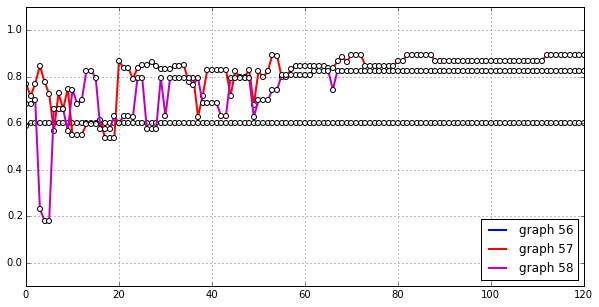

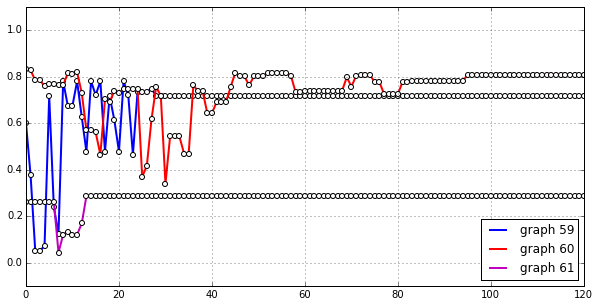

CPU times: user 811 ms, sys: 99.8 ms, total: 911 ms
Wall time: 1.07 s


In [46]:
%%time
# plot score changes during sampling path
from itertools import islice
import numpy as np
import pylab as plt
step=n_steps
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None', markerfacecolor='white', marker='o', markeredgewidth=1,markersize=5)
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()